El EDA es una fase importante para comprender los datos antes de realizar cualquier análisis o construir modelos.

Considero que, EN PARTE, ya lo he aplicado para el desarrollo de cada una de las consignas previas.

A continuacion observamos algunos análisis de los datos, orientado a donde después aplicaría el modelo de ML.

Primero desarrollamos un DF  entre la base de datos de juegos y las reviews.

In [13]:
import pandas as pd
import json
import ast

In [14]:
rows = []
with open('Datasets/steam_games.json', 'r') as f:
        for line in f.readlines():
            data = json.loads(line)
            rows.append(data)

dfgames = pd.DataFrame(rows)
dfgames.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
rows2 = []
with open('Datasets/user_reviews.json', 'rt',encoding= 'utf-8') as f:
    for line in f.readlines():
        rows2.append(ast.literal_eval(line))
dfreviews = pd.DataFrame(rows2)
dfreviews.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [16]:
dfgames.dropna(how='all', inplace=True)
dfreviews.dropna(how='all', inplace=True)

In [17]:
dfgames=dfgames[['id','genres']]

In [18]:
dfreviews = dfreviews.explode('reviews')
dfreviews['item_id'] = dfreviews['reviews'].apply(lambda x: x.get('item_id') if isinstance(x, dict) else '')
dfreviews['recommend'] = dfreviews['reviews'].apply(lambda x: x.get('recommend') if isinstance(x, dict) else '')
dfreviews['review'] = dfreviews['reviews'].apply(lambda x: x.get('review') if isinstance(x, dict) else '')

In [19]:
dfreviews=dfreviews[['user_id','item_id','recommend','review']]


In [20]:
df_merged = dfreviews.merge(dfgames, left_on='item_id', right_on='id', how='left')
df_merged.head()

,user_id,item_id,recommend,review,id,genres
0,76561197970982479,1250,True,Simple yet with great replayability. In my opi...,1250,[Action]
1,76561197970982479,22200,True,It's unique and worth a playthrough.,22200,"[Action, Indie]"
2,76561197970982479,43110,True,Great atmosphere. The gunplay can be a bit chu...,NaN,NaN
3,js41637,251610,True,I know what you think when you see this title ...,NaN,NaN
4,js41637,227300,True,For a simple (it's actually not all that simpl...,227300,"[Indie, Simulation]"


In [21]:
df_merged = df_merged.dropna(subset=['id', 'genres'])


In [22]:
from textblob import TextBlob
# Función para realizar el análisis de sentimiento
def sentiment_analysis(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity
        if polarity < 0:
            return 0  # Sentimiento negativo
        elif polarity == 0:
            return 1  # Sentimiento neutral
        else:
            return 2  # Sentimiento positivo
    else:
        return 1  # Valor por defecto para valores nulos o no strings

# Aplicar la función a la columna 'review' y crear la nueva columna 'sentiment_analysis'
df_merged['sentiment_analysis'] = df_merged['review'].apply(sentiment_analysis)


In [23]:
dfreviews=dfreviews[['user_id','item_id','recommend','review']]

In [24]:
df_merged['item_id'] = df_merged['item_id'].astype(int)

In [ ]:
df_merged.drop(columns=['review','id'], inplace=True)

Exploración inicial de datos:

In [27]:
df_merged.head()

,user_id,item_id,recommend,genres,sentiment_analysis
0,76561197970982479,1250,True,[Action],2
1,76561197970982479,22200,True,"[Action, Indie]",2
4,js41637,227300,True,"[Indie, Simulation]",0
5,js41637,239030,True,"[Adventure, Indie]",0
6,evcentric,248820,True,"[Action, Indie, RPG]",2


In [29]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50451 entries, 0 to 59332
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             50451 non-null  object
 1   item_id             50451 non-null  int64 
 2   recommend           50451 non-null  object
 3   genres              50451 non-null  object
 4   sentiment_analysis  50451 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


* Información General:

El DataFrame tiene 50,451 filas y 5 columnas \\ No hay valores nulos en ninguna de las columnas.
* Columnas Categóricas:

user_id, item_id,recommend, y genres son columnas categóricas.

user_id contiene identificadores de usuarios.

item_id contiene identificadores de juegos.

recommend es una columna categórica booleana que indica si se recomienda un juego.

genres es una lista de géneros de juegos, esta la utilizaremos en el Modelo de ML para realizar una conversión one-hot.

* Columnas Numéricas:

sentiment_analysis medida numérica relacionada con el análisis de sentimientos. 0: Negativo ; 1: Neutro ; 2: Positivo

In [31]:
df_merged.isnull().sum()

user_id               0
item_id               0
recommend             0
genres                0
sentiment_analysis    0
dtype: int64

Análisis de distribuciones:


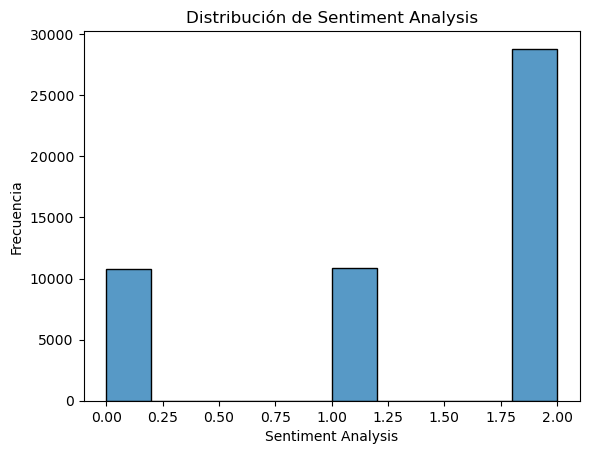

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogramas de 'sentiment_analysis'
sns.histplot(df_merged['sentiment_analysis'], bins=10)
plt.xlabel('Sentiment Analysis')
plt.ylabel('Frecuencia')
plt.title('Distribución de Sentiment Analysis')
plt.show()

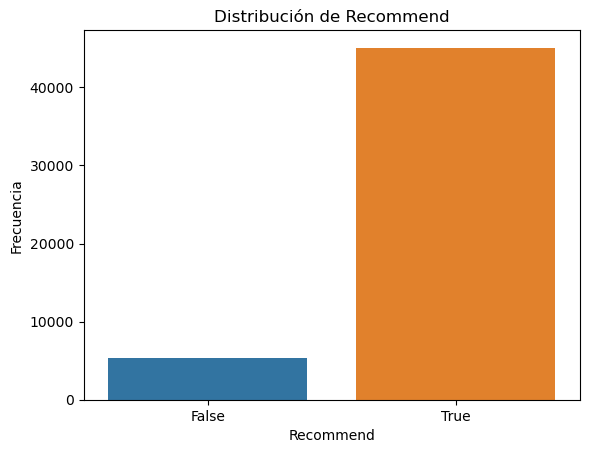

In [34]:

# Gráfico de barras para 'recommend'
sns.countplot(data=df_merged, x='recommend')
plt.xlabel('Recommend')
plt.ylabel('Frecuencia')
plt.title('Distribución de Recommend')
plt.show()

Resumen de Sentimientos:

In [37]:
media_sentimientos = df_merged['sentiment_analysis'].mean()
desviacion_sentimientos = df_merged['sentiment_analysis'].std()

print(f"Media de Sentimientos: {media_sentimientos}")
print(f"Desviación Estándar de Sentimientos: {desviacion_sentimientos}")

Media de Sentimientos: 1.3579116370339537
Desviación Estándar de Sentimientos: 0.8099014313147952


1. **Media de Sentimientos (Polaridad Promedio):**
   - La media de sentimientos es aproximadamente 1.36, lo que sugiere que, en promedio, las opiniones tienden a ser más positivas que negativas.
   - Un valor de 1.36 está más cerca del extremo positivo (2) en la escala de sentimientos, lo que indica que las opiniones tienden a ser más positivas en general.

2. **Desviación Estándar de Sentimientos (Variabilidad):**
   - La desviación estándar de sentimientos es aproximadamente 0.81, lo que indica una moderada variabilidad en las puntuaciones de análisis de sentimientos.
   - Esta variabilidad sugiere que hay una gama de opiniones, con algunas opiniones más negativas y otras más positivas.

En resumen, los resultados indican que, en promedio, las opiniones son positivas, pero existe una variabilidad significativa en las puntuaciones de análisis de sentimientos.

Exploramos ahora estos sentimientos contrastando con lo que recomienda o no los usuarios:

In [38]:
media_sentimientos_recomendados = df_merged[df_merged['recommend'] == True]['sentiment_analysis'].mean()
media_sentimientos_no_recomendados = df_merged[df_merged['recommend'] == False]['sentiment_analysis'].mean()

print(f"Media de Sentimientos para Juegos Recomendados: {media_sentimientos_recomendados}")
print(f"Media de Sentimientos para Juegos No Recomendados: {media_sentimientos_no_recomendados}")

Media de Sentimientos para Juegos Recomendados: 1.4257513585449706
Media de Sentimientos para Juegos No Recomendados: 0.7879239657100261


La relación entre las puntuaciones de análisis de sentimientos y la recomendación de juegos (recomendados vs. no recomendados) es notable y puede ofrecer algunas conclusiones interesantes:

1. **Diferencia en la Media de Sentimientos:**
   - La media de sentimientos para juegos recomendados es aproximadamente 1.43, lo que indica que, en promedio, los juegos recomendados tienen puntuaciones de análisis de sentimientos más positivas.

   - Por otro lado, la media de sentimientos para juegos no recomendados es aproximadamente 0.79, lo que sugiere que los juegos no recomendados tienen puntuaciones de análisis de sentimientos más bajas en promedio.

2. **Implicaciones:**
   - La diferencia significativa en la media de sentimientos entre juegos recomendados y no recomendados sugiere que los juegos recomendados tienden a recibir opiniones más positivas por parte de los usuarios.

3. **Potencial para la Función de Recomendación:**
   - Estos hallazgos pueden ser útiles para mejorar aún más la función de recomendación. Por ejemplo, se puede considerar priorizar juegos con puntuaciones de análisis de sentimientos más altas al generar recomendaciones.

   - También se podría explorar cómo otras variables, como los géneros de los juegos, interactúan con las puntuaciones de análisis de sentimientos y la recomendación, para proporcionar recomendaciones más precisas y personalizadas a los usuarios.

En resumen, la diferencia en la media de sentimientos entre juegos recomendados y no recomendados indica una relación clara entre la recomendación y las opiniones de los usuarios. Esto sugiere que la función de recomendación se basa en parte en la satisfacción de los usuarios con los juegos y que las opiniones positivas influyen en las recomendaciones.

In [39]:
df_merged.to_csv('eda.csv', index=False)